<a href="https://colab.research.google.com/github/nitalutfiyah/nitalutfiyah/blob/main/UAS_SISCER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**UAS Sistem Cerdas**
##Klasifikasi Citra Kanker Serviks Menggunakan Metode CNN Model SqueezeNet

####1. Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil 
import pandas as pd 
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from time import time
import cv2

print(os.listdir("/content/drive/MyDrive/UAS SISCER/Train"))

['normal_columnar', 'light_dysplastic', 'moderate_dysplastic', 'carcinoma_in_situ']


####2. Load Data

In [ ]:
data_dir1 = "/content/drive/MyDrive/UAS SISCER/Train"
data_dir1 = pathlib.Path(data_dir1)

/content/drive/MyDrive/UAS SISCER/Train/normal_columnar/153956040-153956058-003.BMP


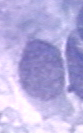

In [ ]:
#Contoh gambar pada folder normal_columnar

sel = list(data_dir1.glob('normal_columnar/*'))
print(sel[0])
PIL.Image.open(str(sel[0]))

####3. Klasifikasi Data

In [ ]:
img_height = 180
img_width = 180
batch_size = 32

#Spliting Data

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir1,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir1,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 568 files belonging to 4 classes.
Using 455 files for training.
Found 568 files belonging to 4 classes.
Using 113 files for validation.


In [ ]:
class_names = train_ds.class_names
print("Macam-Macam Kelas Prediksi:")
print(class_names)

Macam-Macam Kelas Prediksi:
['carcinoma_in_situ', 'light_dysplastic', 'moderate_dysplastic', 'normal_columnar']


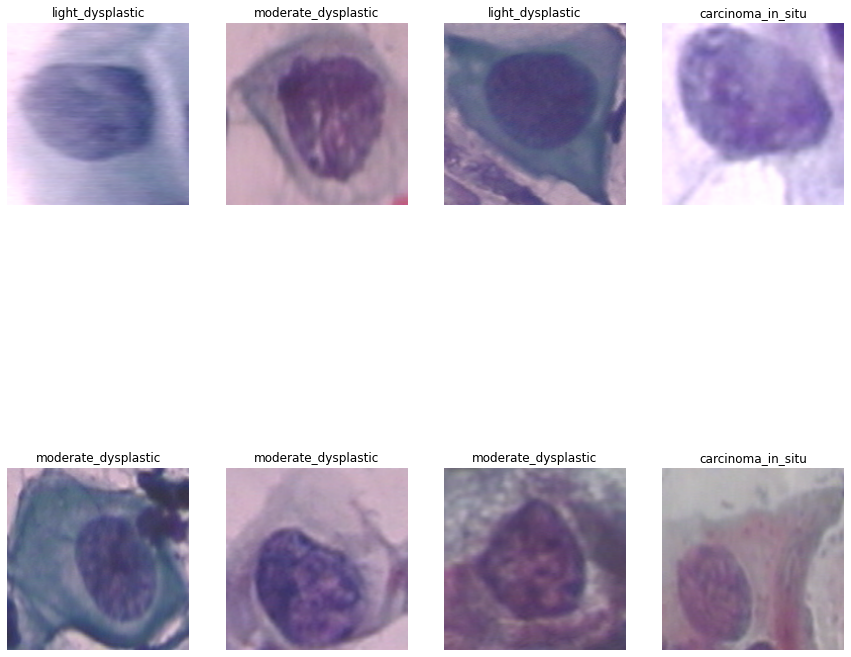

In [ ]:
#Visualisasi Data

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

####4. Training Mode SqueezeNet

In [ ]:
def squeezenet(input_shape, n_classes):
  
  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 32, 128)
  x = fire(x, 48, 192)
  x = fire(x, 48, 192)
  x = fire(x, 64, 256)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 64, 256)
  x = Conv2D(n_classes, 1)(x)
  x = GlobalAvgPool2D()(x)
  
  output = Activation('softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
#model architecture
input_shape=(img_height,img_width,3)
n_classes=7
K.clear_session()
model=squeezenet(input_shape,n_classes)
loss_history=[]
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 96)   14208       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 45, 45, 96)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 45, 45, 16)   1552        ['max_pooling2d[0][0]']      

In [ ]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
#Training 1000 epoch
epochs = 1000
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/1000
15/15 [==============================] - 2s 91ms/step - loss: 1.3657 - accuracy: 0.3275 - val_loss: 1.3605 - val_accuracy: 0.2743
Epoch 2/1000
15/15 [==============================] - 2s 86ms/step - loss: 1.3665 - accuracy: 0.3275 - val_loss: 1.3586 - val_accuracy: 0.2743
Epoch 3/1000
15/15 [==============================] - 2s 86ms/step - loss: 1.3664 - accuracy: 0.3275 - val_loss: 1.3608 - val_accuracy: 0.2743
Epoch 4/1000
15/15 [==============================] - 2s 86ms/step - loss: 1.3654 - accuracy: 0.3275 - val_loss: 1.3607 - val_accuracy: 0.2743
Epoch 5/1000
15/15 [==============================] - 2s 87ms/step - loss: 1.3662 - accuracy: 0.3275 - val_loss: 1.3614 - val_accuracy: 0.2743
Epoch 6/1000
15/15 [==============================] - 2s 89ms/step - loss: 1.3664 - accuracy: 0.3275 - val_loss: 1.3603 - val_accuracy: 0.2743
Epoch 7/1000
15/15 [==============================] - 2s 102ms/step - loss: 1.3665 - accuracy: 0.3275 - val_loss: 1.3624 - val_accuracy: 0.274

####4. Evaluasi

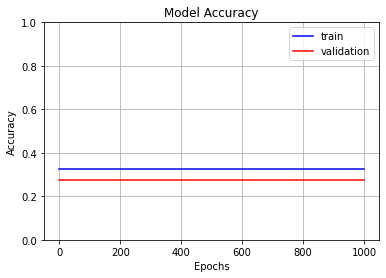

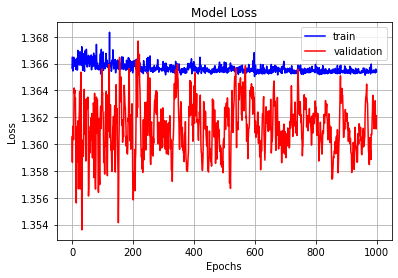

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'],'b-')
plt.plot(history.history['val_accuracy'],'r-')
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'],'b-')
plt.plot(history.history['val_loss'],'r-')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
# Checking the Accuracy of the Model 
accuracy = model.evaluate_generator(generator= train_ds)[1] 
print(f"The accuracy of train is {accuracy*100} %")

NameError: ignored

####5. Test Prediksi

In [ ]:
data_dir = "/content/drive/MyDrive/UAS SISCER/Test"
data_dir = pathlib.Path(data_dir)
test = list(data_dir.glob('light_dysplastic/148495491-148495504-001.BMP')) #Ngambil salah satu foto light_dysplastic

image=cv2.imread(str(test[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
print(test)

pred=model.predict(image)
print(pred)

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class) #harusnya light_dysplastic

(1, 180, 180, 3)
[PosixPath('/content/drive/MyDrive/UAS SISCER/Test/light_dysplastic/148495491-148495504-001.BMP')]
[[2.4627495e-01 3.2550389e-01 2.4216431e-01 1.8605638e-01 1.5430135e-07
  1.5625071e-07 1.5817547e-07]]
The predicted class is light_dysplastic


In [ ]:
data_dir = "/content/drive/MyDrive/UAS SISCER/Test"
data_dir = pathlib.Path(data_dir)
test = list(data_dir.glob('carcinoma_in_situ/149143370-149143378-002.BMP')) #Ngambil salah satu foto carcinoma_in_situ

image=cv2.imread(str(test[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
print(test)

pred=model.predict(image)
print(pred)

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class) #harusnya carcinoma_in_situ

(1, 180, 180, 3)
[PosixPath('/content/drive/MyDrive/UAS SISCER/Test/carcinoma_in_situ/149143370-149143378-002.BMP')]
[[2.4627495e-01 3.2550389e-01 2.4216431e-01 1.8605638e-01 1.5430135e-07
  1.5625071e-07 1.5817547e-07]]
The predicted class is light_dysplastic


In [ ]:
data_dir = "/content/drive/MyDrive/UAS SISCER/Test"
data_dir = pathlib.Path(data_dir)
test = list(data_dir.glob('moderate_dysplastic/148848523-148848559-001.BMP')) #Ngambil salah satu foto moderate_dysplastic

image=cv2.imread(str(test[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
print(test)

pred=model.predict(image)
print(pred)

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class) #harusnya moderate_dysplastic

(1, 180, 180, 3)
[PosixPath('/content/drive/MyDrive/UAS SISCER/Test/moderate_dysplastic/148848523-148848559-001.BMP')]
[[2.4627495e-01 3.2550389e-01 2.4216431e-01 1.8605638e-01 1.5430135e-07
  1.5625071e-07 1.5817547e-07]]
The predicted class is light_dysplastic


In [ ]:
data_dir = "/content/drive/MyDrive/UAS SISCER/Test"
data_dir = pathlib.Path(data_dir)
test = list(data_dir.glob('normal_columnar/153956040-153956058-001.BMP')) #Ngambil salah satu foto normal_columnar

image=cv2.imread(str(test[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
print(test)

pred=model.predict(image)
print(pred)

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class) #harusnya normal_columnar

(1, 180, 180, 3)
[PosixPath('/content/drive/MyDrive/UAS SISCER/Test/normal_columnar/153956040-153956058-001.BMP')]
[[2.4627495e-01 3.2550389e-01 2.4216431e-01 1.8605638e-01 1.5430135e-07
  1.5625071e-07 1.5817547e-07]]
The predicted class is light_dysplastic
